# 多层感知机的简洁实现
:label:`sec_mlp_concise`

本节将介绍(**通过高级API更简洁地实现多层感知机**)。


In [1]:
import torch
from torch import nn
# from d2l import torch as d2l

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是[**隐藏层**]，它(**包含256个隐藏单元，并使用了ReLU激活函数**)。
第二层是输出层。


In [10]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

[**训练过程**]的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。


In [3]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [9]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

import matplotlib.pyplot as plt
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

NameError: name 'net' is not defined

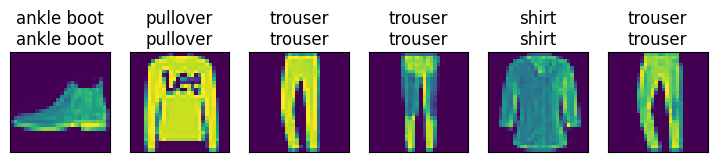

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 我们可以使用高级API更简洁地实现多层感知机。
* 对于相同的分类问题，多层感知机的实现与softmax回归的实现相同，只是多层感知机的实现里增加了带有激活函数的隐藏层。

## 练习

1. 尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？
1. 尝试不同的激活函数，哪个效果最好？
1. 尝试不同的方案来初始化权重，什么方法效果最好？


KeyboardInterrupt: 

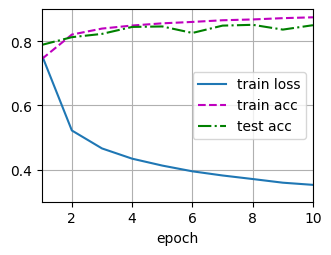

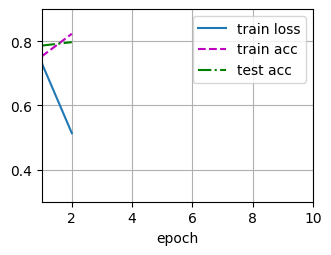

In [8]:
import torch
from torch import nn

# 定义不同的初始化函数
def init_weights_normal(m):
    """标准正态分布初始化"""
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        # 可选：初始化偏置
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_xavier(m):
    """Xavier均匀分布初始化"""
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_he(m):
    """He初始化（Kaiming初始化）"""
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_orthogonal(m):
    """正交初始化"""
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# 创建网络模型的框架函数
def create_and_initialize_model(hidden_layers_config, init_method='normal'):
    """
    创建并初始化多层感知机模型
    
    参数:
    hidden_layers_config: 隐藏层配置列表，如 [256, 128, 64] 表示3个隐藏层
    init_method: 初始化方法 ('normal', 'xavier', 'he', 'orthogonal')
    """
    
    # 构建网络层
    layers = [nn.Flatten()]
    
    # 输入层到第一个隐藏层
    layers.append(nn.Linear(784, hidden_layers_config[0]))
    layers.append(nn.ReLU())
    
    # 隐藏层之间连接
    for i in range(len(hidden_layers_config) - 1):
        layers.append(nn.Linear(hidden_layers_config[i], hidden_layers_config[i+1]))
        layers.append(nn.ReLU())
    
    # 最后一个隐藏层到输出层
    layers.append(nn.Linear(hidden_layers_config[-1], 10))
    
    # 创建网络
    net = nn.Sequential(*layers)
    
    # 根据指定方法初始化权重
    if init_method == 'normal':
        net.apply(init_weights_normal)
    elif init_method == 'xavier':
        net.apply(init_weights_xavier)
    elif init_method == 'he':
        net.apply(init_weights_he)
    elif init_method == 'orthogonal':
        net.apply(init_weights_orthogonal)
    else:
        raise ValueError(f"未知的初始化方法: {init_method}")
    
    return net

# 使用示例
if __name__ == "__main__":
    # 不同的网络结构配置
    network_configs = [
        [256],           # 1个隐藏层，256个单元
        [512, 256],      # 2个隐藏层
        # [512, 256, 128], # 3个隐藏层
        # [1024, 512, 256, 128] # 4个隐藏层
    ]
    
    # 不同的初始化方法
    init_methods = ['xavier', 'he', 'orthogonal', 'normal']
    
    # 存储不同配置的模型
    models = {}
    
    # 为每种网络结构和初始化方法创建模型
    for config in network_configs:
        config_name = f"layers_{'_'.join(map(str, config))}"
        models[config_name] = {}
        
        for method in init_methods:
            model = create_and_initialize_model(config, method)
            models[config_name][method] = model
            print(f"创建模型: {config_name} + {method} 初始化")
            
            # 可以在这里添加训练代码
            # train_model(model, train_iter, test_iter, ...)
            batch_size, lr, num_epochs = 256, 0.1, 10
            loss = nn.CrossEntropyLoss(reduction='none')
            trainer = torch.optim.SGD(model.parameters(), lr=lr)
            train_iter, test_iter = load_data_fashion_mnist(batch_size)
            train_ch3(model, train_iter, test_iter, loss, num_epochs, trainer)

[Discussions](https://discuss.d2l.ai/t/1802)
